<a href="https://colab.research.google.com/github/pratikshakirolkar/Electricity-Consumption-Project/blob/main/LGBM_multistep_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
import warnings
warnings.filterwarnings("ignore")
import lightgbm as lgb
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error
print('Setup complete')

Setup complete


In [2]:
file = '/content/household_power_consumption.txt.zip'
# read the datafile
df = pd.read_table(file, delimiter=';', low_memory=False)


In [3]:

#replace string values in numerical columns to null values 
df.replace('?', 'NaN', inplace=True)

#transfer data dtypes
for cl in df.columns[2:8]:
    df[cl] = df[cl].astype('float64')

# calculate not measured electricity (in watt-hour), name it n here
df['Sub_metering_n'] = df.Global_active_power*1000/60 - df.Sub_metering_1 - df.Sub_metering_2 - df.Sub_metering_3

In [4]:

# fill null values
df.interpolate(axis=0, inplace=True)

In [5]:
df['datetime'] = pd.to_datetime(df['Date']+ ' ' + df['Time'], dayfirst=True)
df.index = df['datetime'] 
df = df.drop(['Date', 'Time', 'datetime'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
 7   Sub_metering_n         float64
dtypes: float64(8)
memory usage: 142.5 MB


<AxesSubplot:xlabel='datetime'>

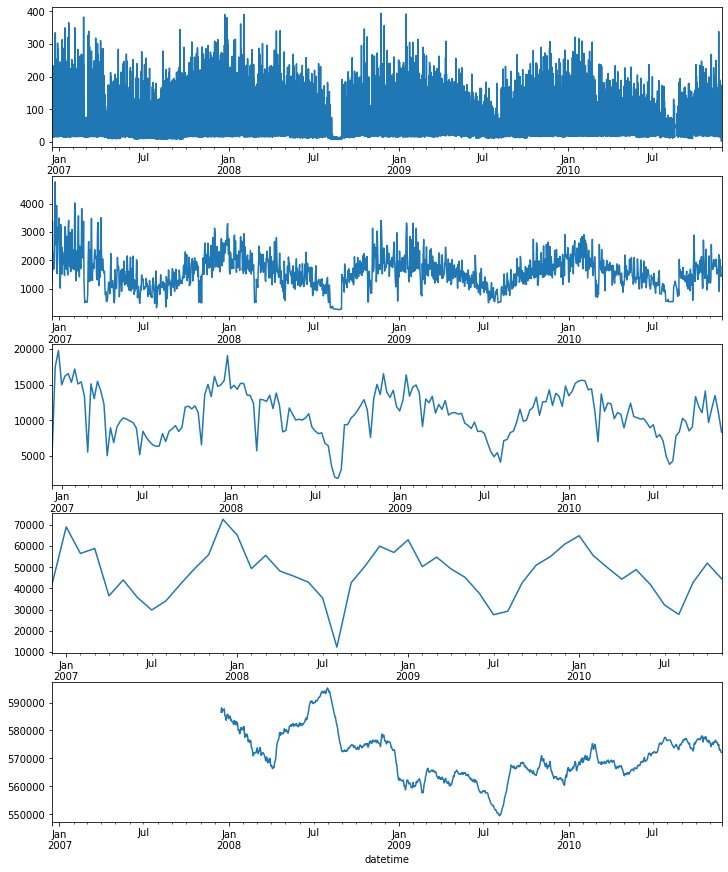

In [6]:
fig, axs = plt.subplots(5, 1, figsize=(12,15))
df.resample('H').sum()['Global_active_power'].plot(ax=axs[0])
df.resample('D').sum()['Global_active_power'].plot(ax=axs[1])
df.resample('W').sum()['Global_active_power'].plot(ax=axs[2])
df.resample('M').sum()['Global_active_power'].plot(ax=axs[3])
df.resample('D').sum().rolling(365).sum()['Global_active_power'].plot(ax=axs[4])

Firstly, I investigated the electric power consumption patterns in different living areas.

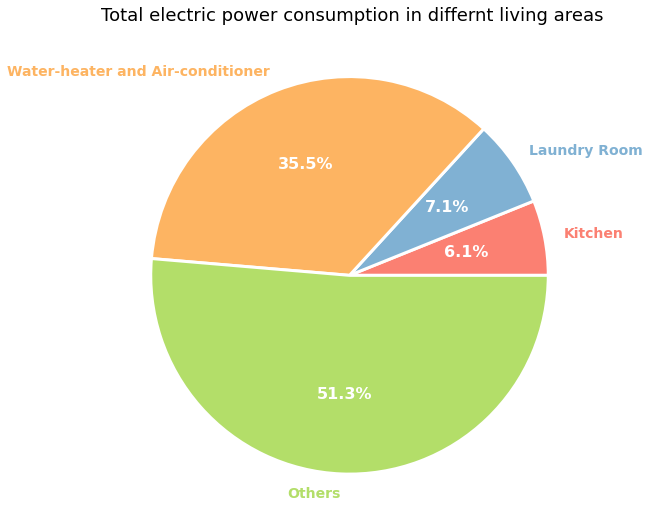

In [7]:
cls = ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Sub_metering_n']
pie_data = df[cls].sum(axis=0)
labels = ['Kitchen', 'Laundry Room', 'Water-heater and Air-conditioner', 'Others']

plt.figure(figsize=(9,9))
colors = sns.color_palette('Set3')[3:]
patches, texts, pcts = plt.pie(
                            pie_data, labels=labels, 
                            colors=colors,
                            autopct='%.1f%%',
                            wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
                            startangle=0
)

for i, patch in enumerate(patches):
  texts[i].set_color(patch.get_facecolor())
plt.setp(pcts, color='white', fontsize=16, fontweight='bold')
plt.setp(texts, fontsize=14, fontweight='bold')
plt.title('Total electric power consumption in differnt living areas', fontsize=18, loc='left')
plt.tight_layout()

From the chart above we can see about half of the electric power is consumed in living areas other than the kitchen, laundry room or water-heater and air-conditioner, where the electric power consumption of air-conditioner and water-heater accounts for 35% of the total consumption. The kitchen and laundry room account for 13% of the total.

Then I investigated the daily electric power consumption patterns

In [8]:
df_hour = df.resample('H').sum()
df_hour['hour'] = df_hour.index.hour
# to investigate the hourly pattern, average the dataset by minute
df_hour = df_hour.groupby('hour').mean()

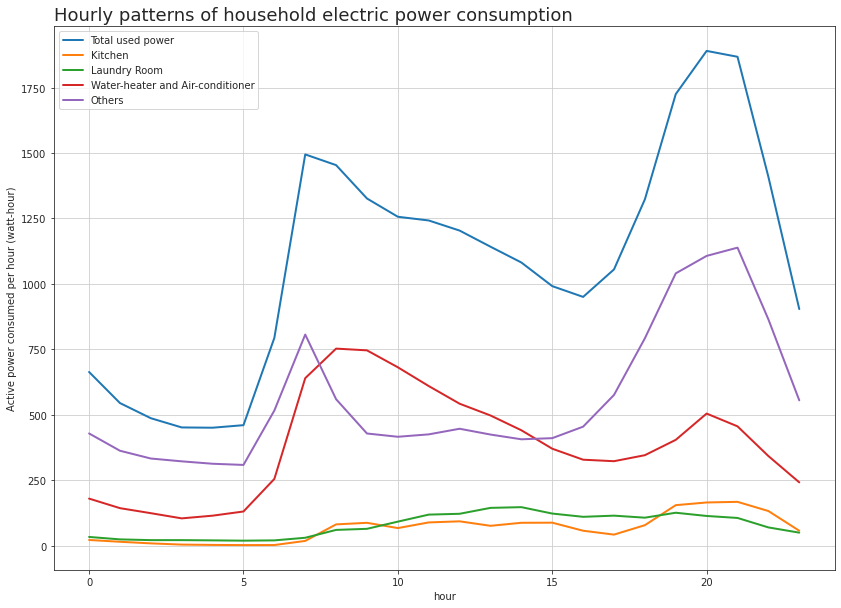

In [9]:
#plot the houly pattern
sns.set_style("ticks",{'axes.grid' : True})
fig, ax = plt.subplots(1, 1, figsize=(14,10))
ax.plot(df_hour.index, df_hour.Global_active_power*1000/60, linewidth=2, label='Total used power')
for i in range(4,8):
    ax.plot(df_hour.index, df_hour[df_hour.columns[i]], linewidth=2, label=labels[i-4])
plt.xlabel('hour')
plt.ylabel('Active power consumed per hour (watt-hour)')
plt.title('Hourly patterns of household electric power consumption', fontsize=18, loc='left')
plt.legend()

From the hourly pattern (averaged by day), we can see the power consumption increases at day time and decreases at night time. During the daytime, in areas like air-conditioner, kitchen and others (which might include living rooms, bedrooms, etc), the electric power consumption keeps decreasing from 7 am to 5 pm, then goes up until 9 pm, where the electric power consumption in the laundry room is relatively flat compared to other areas in the house.